# Autoregression

Overview of autoregressive recurrent model for time series predictions.

## Setup

In [ ]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from skimage import io
from sklearn import metrics
from matplotlib import pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (16, 9)
sns.set()

## Data Generator

Use `WindowGenerator` class

In [ ]:
class WindowGenerator:
    def __init__(
        self,
        data,
        *,
        input_window_size,
        output_window_size,
        shift=1,
        test_size=0.0,
        start_date=None,
        end_date=None,
        feature_columns=None,
        target_columns=None,
    ):
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size
        self.shift = shift
        start_date = start_date or data.index[0]
        end_date = end_date or data.index[-1]
        # split data set
        data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
        self.train_df = data[:int(len(data) * (1 - test_size))]
        self.test_df = data[int(len(data) * (1 - test_size)):]
        # map column names to indices
        self.column_index = {column: index for index, column in enumerate(data.columns.tolist())}
        # use all columns by default
        self.feature_columns = [self.column_index[column] for column in feature_columns] if feature_columns else [self.column_index[column] for column in data.columns.tolist()]
        self.target_columns = [self.column_index[column] for column in target_columns] if target_columns else [self.column_index[column] for column in data.columns.tolist()]

    def split(self, data):
        features, targets = [], []
        for index in list(range(len(data)))[::self.shift]:
            if index + self.input_window_size + self.output_window_size >= len(data):
                break
            features.append(data[index: index + self.input_window_size, self.feature_columns])

            targets.append(data[
                index + self.input_window_size: index + self.input_window_size + self.output_window_size,
                self.target_columns
            ])

        return np.asarray(features), np.asarray(targets)

    @staticmethod
    def filter_nan(features, targets):
        feature_index = np.apply_over_axes(np.any, np.isnan(features.astype(float)), axes=[1, 2]).flatten()
        target_index = np.apply_over_axes(np.any, np.isnan(targets.astype(float)), axes=[1, 2]).flatten()
        valid_index = np.logical_and(~feature_index, ~target_index)

        return features[valid_index], targets[valid_index]

    @property
    def train(self):
        return self.filter_nan(*self.split(self.train_df.values))

    @property
    def test(self):
        return self.filter_nan(*self.split(self.test_df.values))


## Toy Data

Generate toy data set to illustrate how model works internally. Use simple sine and cosine waves.

In [ ]:
index = pd.date_range(pd.Timestamp(year=2015, month=1, day=1), pd.Timestamp(year=2015, month=3, day=10), freq="T")

In [ ]:
t = np.linspace(0, 1024*np.pi, 97921)
toy_data = np.vstack([np.sin(t), np.cos(t), np.sin(2*t) + np.cos(2*t), -np.cos(0.5*t)]).T
toy_df = pd.DataFrame.from_records(toy_data, columns=["sin", "cos", "sin + cos", "cos(0.5t)"])
toy_df.index = index

In [ ]:
generator = WindowGenerator(toy_df, input_window_size=30, output_window_size=30, shift=10, test_size=0.3)

In [ ]:
features, targets = generator.train

# Autoregressive Model

Create simple model with one LSTMCell (processes one step instead of whole sequence) and final Dense layer.

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        

In [ ]:
feedback_model = FeedBack(units=32, out_steps=30)

Use 1 data point to see how warmup method shuld work. It returns tensor with shape (batch_size, lstm_units).

In [ ]:
x, *states = feedback_model.lstm_rnn(tf.expand_dims(features[0], axis=0))
x.shape  # shape => (batch_size, lstm_units)

TensorShape([1, 32])

Each LSTM unit outputs prediction one step ahead into the future. It also outputs its states. Thanks to RNN layer, in which LSTMCell is wrapper in, the whole input sequence can be generated as once and states are kept. This will be useful in predictions.

In [ ]:
print(type(states))

for state in states:
    # hidden state for each LSTM unit
    print(state.shape)

<class 'list'>
(1, 32)
(1, 32)


Create `Feedback` class again with added `Dense` layer.

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        # add a Dense layer
        self.dense = tf.keras.layers.Dense(4)

feedback_model = FeedBack(units=32, out_steps=30)

Warmup method processes whole sequence and keeps the states. Using this in `LSTMCell` would require using a for loop, but `tf.keras.layers.RNN` layer simplifies this.

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

Warmup is used to generate first prediction and to initizalize hidden state of the model. 

In [ ]:
prediction, state = feedback_model.warmup(tf.expand_dims(features[0], axis=0))
prediction.shape  # outputs => (batch_size, n_features)

TensorShape([1, 4])

Unwrap call method step by step.

In [ ]:
predictions = []
# Initialize the lstm state
prediction, state = feedback_model.warmup(tf.expand_dims(features[0], axis=0))
prediction.shape

TensorShape([1, 4])

Prediction contains 4 random values.

In [ ]:
prediction.numpy()

array([[ 0.01008324, -0.09336833, -0.09517028,  0.09882881]],
      dtype=float32)

In [ ]:
predictions.append(prediction)

for n in range(1, 30):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = feedback_model.lstm_cell(x, states=state, training=False)
    # Convert the lstm output to a prediction.
    prediction = feedback_model.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)
    print(f"Step: {n} Output: {prediction.numpy()}")

Step: 1 Output: [[-0.00261619 -0.08876835 -0.0600556   0.10480354]]
Step: 2 Output: [[-0.00319259 -0.0678205   0.00968092  0.10650828]]
Step: 3 Output: [[ 0.00065079 -0.04977826  0.05569864  0.10053096]]
Step: 4 Output: [[ 0.00613908 -0.03449655  0.0828424   0.0910911 ]]
Step: 5 Output: [[ 0.01136435 -0.0218053   0.09608275  0.08080118]]
Step: 6 Output: [[ 0.01537028 -0.01145978  0.09959184  0.07096658]]
Step: 7 Output: [[ 0.01788682 -0.00321074  0.09670455  0.06211985]]
Step: 8 Output: [[0.01902476 0.00317942 0.08996412 0.05439512]]
Step: 9 Output: [[0.01905686 0.00794112 0.08122124 0.0477454 ]]
Step: 10 Output: [[0.0182907  0.01130096 0.07175594 0.04205304]]
Step: 11 Output: [[0.01700602 0.01348073 0.06240163 0.03718228]]
Step: 12 Output: [[0.0154306  0.01469345 0.05365831 0.03300244]]
Step: 13 Output: [[0.01373641 0.01513825 0.04578778 0.0293973 ]]
Step: 14 Output: [[0.01204489 0.01499564 0.03888968 0.02626775]]
Step: 15 Output: [[0.01043592 0.01442409 0.03295925 0.02353135]]
Step: 

In [ ]:
predictions = tf.stack(predictions)
# predictions.shape => (batch, time, features)
predictions = tf.transpose(predictions, [1, 0, 2])

Wrap this is a single function.

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
feedback_model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
history = feedback_model.fit(features, targets, epochs=10, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=2)])

Epoch 1/10
193/193 [==============================] - 11s 25ms/step - loss: 0.3645 - mse: 0.3645 - mae: 0.4716 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0718
Epoch 2/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0557 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0376
Epoch 3/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0361 - val_loss: 0.0030 - val_mse: 0.0030 - val_mae: 0.0275
Epoch 4/10
193/193 [==============================] - 4s 19ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0288 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0279


## Evaluate Model

Use regression metrics to evalaute model.

In [ ]:
def regression_report(y_true, y_pred, precision=2):
    print(f"MSE: {metrics.mean_squared_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"MAE: {metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"MAX: {metrics.max_error(y_true=y_true, y_pred=y_pred):.4f}")
    print(f"R2:  {metrics.r2_score(y_true=y_true, y_pred=y_pred):.4f}")

On toy dataset, model performs really well.

In [ ]:
test_features, test_targets = generator.test
predictions = feedback_model.predict(test_features)

regression_report(y_true=test_targets.flatten(), y_pred=predictions.flatten())

MSE: 0.0028
MAE: 0.0278
MAX: 0.5731
R2:  0.9955


Plot model outputs using `WindowGenerator`.

In [ ]:
def plot_window(generator, column, model=None, dataset="train", n_subplots=3):
    plt.figure(figsize=(12, 8))

    if dataset == "train":
        inputs, labels = generator.train
    
    else:
        inputs, labels = generator.test
    
    indices = np.random.randint(0, len(inputs), 3)
    inputs = inputs[indices, : ,:]
    labels = labels[indices, : ,:]

    plot_col_index = generator.column_index[column]

    if model is not None:
            predictions = model(inputs)
    
    for n in range(n_subplots):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{column}')
        plt.scatter(np.arange(len(labels[n])), labels[n, :, plot_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            plt.scatter(np.arange(len(labels[n])), predictions[n, :, plot_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

    plt.xlabel("Time [min]")

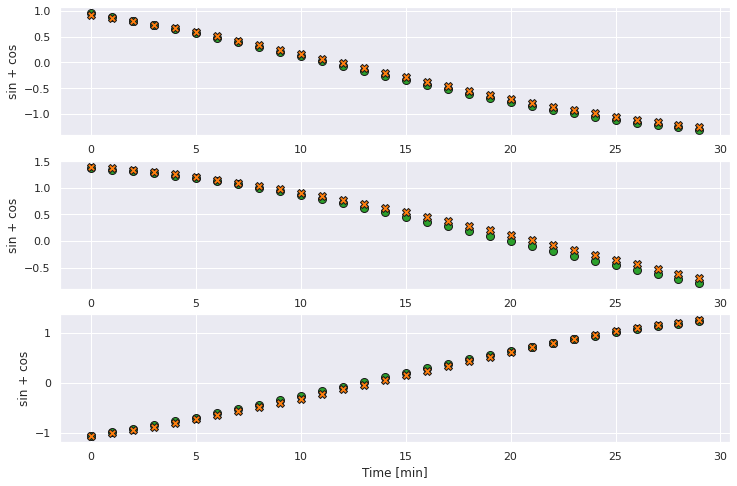

In [ ]:
plot_window(generator, "sin + cos", model=feedback_model, dataset="test")

Unwrap `call` function on fitted model to see what it learned. 

In [ ]:
features, targets = generator.test  # use test data

input = tf.expand_dims(features[0], axis=0)
label = targets[0]

In [ ]:
predictions = []
# Initialize the lstm state
prediction, state = feedback_model.warmup(input)
prediction.shape

TensorShape([1, 4])

Warmup method is sligtly off, but it is small error.

In [ ]:
prediction.numpy().flatten(), label[0]

(array([-0.33354184, -0.92473435,  1.4654303 ,  0.09431899], dtype=float32),
 array([-0.34972651, -0.93685184,  1.41066658,  0.17769097]))

Run unrolling of the input using model.

*Warning* - when this cell is run multiple times model will proceed to generate further samples, so labels and predictions will not match!

In [ ]:
predictions.append(prediction)

for n in range(1, 30):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = feedback_model.lstm_cell(x, states=state, training=False)
    # Convert the lstm output to a prediction.
    prediction = feedback_model.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)
    print(f"Step: {n} Error: {np.sum(prediction.numpy()[0] - targets[0][n]):.4f}")

Step: 1 Error: 0.0000
Step: 2 Error: -0.0088
Step: 3 Error: -0.0165
Step: 4 Error: -0.0239
Step: 5 Error: -0.0310
Step: 6 Error: -0.0377
Step: 7 Error: -0.0440
Step: 8 Error: -0.0496
Step: 9 Error: -0.0545
Step: 10 Error: -0.0586
Step: 11 Error: -0.0615
Step: 12 Error: -0.0632
Step: 13 Error: -0.0634
Step: 14 Error: -0.0617
Step: 15 Error: -0.0581
Step: 16 Error: -0.0526
Step: 17 Error: -0.0453
Step: 18 Error: -0.0365
Step: 19 Error: -0.0267
Step: 20 Error: -0.0167
Step: 21 Error: -0.0071
Step: 22 Error: 0.0011
Step: 23 Error: 0.0073
Step: 24 Error: 0.0110
Step: 25 Error: 0.0118
Step: 26 Error: 0.0096
Step: 27 Error: 0.0047
Step: 28 Error: -0.0026
Step: 29 Error: -0.0115


## Residual Autoregression

Create residual autoregressive model, which instead of predicting values of the time series it learns, predicts just updates from previous step.

In [ ]:
class FeedbackModel(tf.keras.Model):
    def __init__(self, n_input_features, n_output_features, n_input_time_steps, n_output_time_steps):
        super().__init__()
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
        self.n_input_time_steps = n_input_time_steps
        self.n_output_time_steps = n_output_time_steps
        # use two GRU cells 
        self.cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(32), tf.keras.layers.GRUCell(16)])
        self.rnn = tf.keras.layers.RNN(self.cells, return_state=True)
        # add a Dense layer
        self.dense = tf.keras.layers.Dense(n_output_features, kernel_initializer="zeros")

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # initially empty not to break model class
        ...

In [ ]:
features, targets = generator.train
input = tf.expand_dims(features[0], axis=0)

model = FeedbackModel(n_input_features=4, n_output_features=4, n_input_time_steps=30, n_output_time_steps=30)

The `RNN` layer outputs hidden state of last stacked `GRUCell` from the model.

In [ ]:
x, *states = model.rnn(input)
x.shape  # shape => (batch_size, lstm_units)

TensorShape([1, 16])

Create empty predictions and initialize hidden state with `warmup`.

In [ ]:
predictions = tf.TensorArray(size=model.n_output_time_steps, dtype=tf.float32)
# Initialize the lstm state
update, state = model.warmup(input)
update.shape

TensorShape([1, 4])

Unfitted prediction is Tensor of zeros.

In [ ]:
update.numpy()

array([[0., 0., 0., 0.]], dtype=float32)

Slice Tensor to get its last element which contains all features in last time step from current window.

In [ ]:
input[:, -1, :].numpy()

array([[ 0.81500883,  0.57944853,  0.61603255, -0.88866432]])

Write prediction loop. 

In [ ]:
prediction = tf.cast(input[:, -1, :], dtype=tf.float32) + update
# using tf.TensorArray requires returning variables instead of changing
predictions = predictions.write(0, prediction)  # initalize with last input + update

for n in range(1, model.n_output_time_steps):
    # Use the last prediction as input.
    prediction += update 
    x = prediction
    # Execute one lstm step.
    x, state = model.cells(x, states=state, training=False)
    # Convert the lstm output to a prediction.
    update = model.dense(x)
    # Add the prediction to the output
    predictions = predictions.write(n, prediction + update)

    print(f"Step: {n} Update: {update.numpy()} Prediction: {prediction.numpy()}")

Step: 1 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 2 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 3 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 4 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 5 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 6 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 7 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 8 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 9 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 10 Update: [[0. 0. 0. 0.]] Prediction: [[ 0.8150088   0.5794485   0.61603254 -0.8886643 ]]
Step: 11 Update: [[0. 0. 0. 0.]] Predic

Stack prediction stored in dynamical `tf.TensorArray`. Transpose to correct shape

In [ ]:
predictions = predictions.stack()
tf.transpose(predictions, [1, 0, 2]).numpy().shape  # shape => (batch_size, time_steps, features)

(1, 30, 4)

Rewrite  `ResidualFeedbackModel` class with all functions.

In [ ]:
class ResidualFeedbackModel(tf.keras.Model):
    def __init__(self, n_input_features, n_output_features, n_input_time_steps, n_output_time_steps):
        super().__init__()
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
        self.n_input_time_steps = n_input_time_steps
        self.n_output_time_steps = n_output_time_steps
        # use two GRU cells 
        self.cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(32), tf.keras.layers.GRUCell(16)])
        self.rnn = tf.keras.layers.RNN(self.cells, return_state=True)
        self.dense = tf.keras.layers.Dense(n_output_features, kernel_initializer="zeros", use_bias=False)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        # when using tf.keras.layers.StackedRNNCells state must be passed as a tuple!
        return prediction, tuple(state)

    def call(self, inputs, training=None):
        # initially empty not to break model class
        predictions = tf.TensorArray(size=self.n_output_time_steps, dtype=tf.float32)
        update, state = self.warmup(inputs)

        prediction = tf.cast(inputs[:, -1, :], dtype=tf.float32) + update
        predictions = predictions.write(0, prediction)  # initalize with last input + update

        for n in tf.range(1, self.n_output_time_steps):
            # Use the last prediction as input.
            prediction += update 
            x = prediction
            # Execute one lstm step.
            x, state = self.cells(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            update = self.dense(x, training=training)
            # Add the prediction to the output
            predictions = predictions.write(n, prediction + update)

        predictions = predictions.stack()
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

model = ResidualFeedbackModel(n_input_features=4, n_output_features=4, n_input_time_steps=30, n_output_time_steps=30)

### Fit
Fit the model using toy dataset.

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
history = model.fit(features, targets, epochs=10, validation_split=0.1, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/10
193/193 [==============================] - 13s 44ms/step - loss: 0.1633 - mse: 0.1633 - mae: 0.2247 - val_loss: 0.0063 - val_mse: 0.0063 - val_mae: 0.0445
Epoch 2/10
193/193 [==============================] - 8s 43ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0344 - val_loss: 9.3916e-04 - val_mse: 9.3916e-04 - val_mae: 0.0203
Epoch 3/10
193/193 [==============================] - 8s 43ms/step - loss: 6.0348e-04 - mse: 6.0348e-04 - mae: 0.0173 - val_loss: 3.5240e-04 - val_mse: 3.5240e-04 - val_mae: 0.0141
Epoch 4/10
193/193 [==============================] - 8s 42ms/step - loss: 3.2009e-04 - mse: 3.2009e-04 - mae: 0.0131 - val_loss: 2.7117e-04 - val_mse: 2.7117e-04 - val_mae: 0.0122
Epoch 5/10
193/193 [==============================] - 8s 43ms/step - loss: 2.6064e-04 - mse: 2.6064e-04 - mae: 0.0118 - val_loss: 2.3433e-04 - val_mse: 2.3433e-04 - val_mae: 0.0109
Epoch 6/10
193/193 [==============================] - 8s 43ms/step - loss: 2.2457e-04 - mse: 2.2457e-04 - mae: 0.0108 

In [ ]:
test_features, test_targets = generator.test
predictions = model.predict(test_features)

regression_report(y_true=test_targets.flatten(), y_pred=predictions.flatten())

MSE: 0.0002
MAE: 0.0108
MAX: 0.0652
R2:  0.9997


In [ ]:
old_predictions = feedback_model.predict(test_features)
regression_report(y_true=test_targets.flatten(), y_pred=old_predictions.flatten())

MSE: 0.0028
MAE: 0.0278
MAX: 0.5731
R2:  0.9955


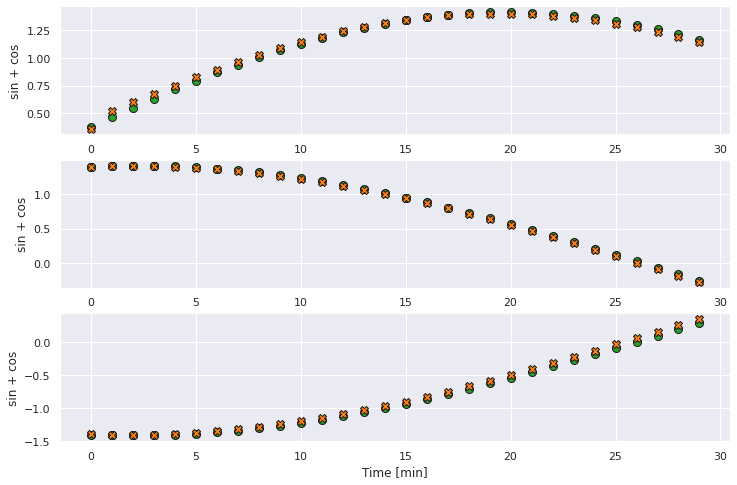

In [ ]:
plot_window(generator, "sin + cos", model=model, dataset="test")

## Unwrap fitted model

In [ ]:
features, targets = generator.test  # use test data

input = tf.expand_dims(features[0], axis=0)
label = targets[0]

In [ ]:
predictions = tf.TensorArray(size=model.n_output_time_steps, dtype=tf.float32)
update, state = model.warmup(input)

prediction = tf.cast(input[:, -1, :], dtype=tf.float32) + update
predictions = predictions.write(0, prediction)  # initalize with last input + update

In [ ]:
for n in tf.range(1, model.n_output_time_steps):
    # Use the last prediction as input.
    prediction += update 
    x = prediction
    # Execute one lstm step.
    x, state = model.cells(x, states=state, training=False)
    # Convert the lstm output to a prediction.
    update = model.dense(x, training=False)
    # Add the prediction to the output
    predictions = predictions.write(n, prediction + update)
    # print just one column 
    print(f"Step: {n} Update: {update.numpy()[:,1][0]:.4f} Prediction: {prediction.numpy()[:,1][0]:.4f} Value: {label[n,1]:.4f}")


Step: 1 Update: 0.0127 Prediction: -0.9244 Value: -0.9249
Step: 2 Update: 0.0136 Prediction: -0.9118 Value: -0.9119
Step: 3 Update: 0.0145 Prediction: -0.8981 Value: -0.8979
Step: 4 Update: 0.0154 Prediction: -0.8836 Value: -0.8829
Step: 5 Update: 0.0162 Prediction: -0.8683 Value: -0.8671
Step: 6 Update: 0.0170 Prediction: -0.8521 Value: -0.8502
Step: 7 Update: 0.0177 Prediction: -0.8351 Value: -0.8325
Step: 8 Update: 0.0185 Prediction: -0.8174 Value: -0.8138
Step: 9 Update: 0.0192 Prediction: -0.7989 Value: -0.7943
Step: 10 Update: 0.0200 Prediction: -0.7796 Value: -0.7739
Step: 11 Update: 0.0207 Prediction: -0.7597 Value: -0.7527
Step: 12 Update: 0.0214 Prediction: -0.7390 Value: -0.7307
Step: 13 Update: 0.0221 Prediction: -0.7177 Value: -0.7078
Step: 14 Update: 0.0227 Prediction: -0.6956 Value: -0.6842
Step: 15 Update: 0.0234 Prediction: -0.6729 Value: -0.6599
Step: 16 Update: 0.0241 Prediction: -0.6495 Value: -0.6349
Step: 17 Update: 0.0247 Prediction: -0.6254 Value: -0.6092
Step: 

## Add Convolutional Inputs

Allow model to process 2D convolutional input, it could be interpreted as time-frequency signal, for example Gabor transform of some periodic signal.

In [ ]:
n_points = len(toy_df)
n_points

97921

In [ ]:
toy_2d_time_series = np.vstack([stats.norm.rvs(size=100, scale=0.1) for _ in range(n_points)])
toy_2d_time_series.shape

(97921, 100)

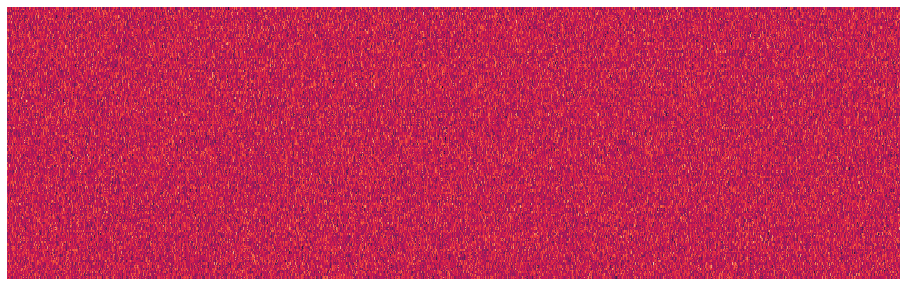

In [ ]:
_ = plt.figure(figsize=[16, 5])

_ = sns.heatmap(toy_2d_time_series.T[:1000], cbar=False, annot=False)
_ = plt.yticks([], [])
_ = plt.xticks([], [])
_ = plt.grid()

Create random indices for events, which will happed in CNN input. This is done to see the influence of CNN model branch on the predictions. 

In [ ]:
events = np.random.randint(0, n_points - 100, 500)
events.shape

(500,)

For each random event, add visible, but randomized bubble, which could be detected by the CNN layer and used as update to the model.

In [ ]:
def get_event():
    x, y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 100))
    
    def signal(x, y):
        return np.sin(np.pi*x) + np.sin(np.pi*y)

    return signal(x, y).T

In [ ]:
for event_id in events.tolist():
    toy_2d_time_series[event_id : event_id+50, :] += get_event()

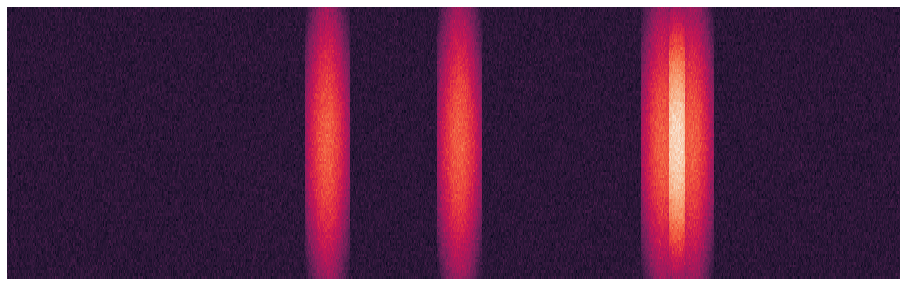

In [ ]:
_ = plt.figure(figsize=[16, 5])

_ = sns.heatmap(toy_2d_time_series[:1000].T, cbar=False, annot=False)
_ = plt.yticks([], [])
_ = plt.xticks([], [])
_ = plt.grid()

In [ ]:
for event_id in events.tolist():
    toy_df["sin + cos"].iloc[event_id : event_id + 50] += np.sin(np.linspace(0, 2*np.pi, 50))

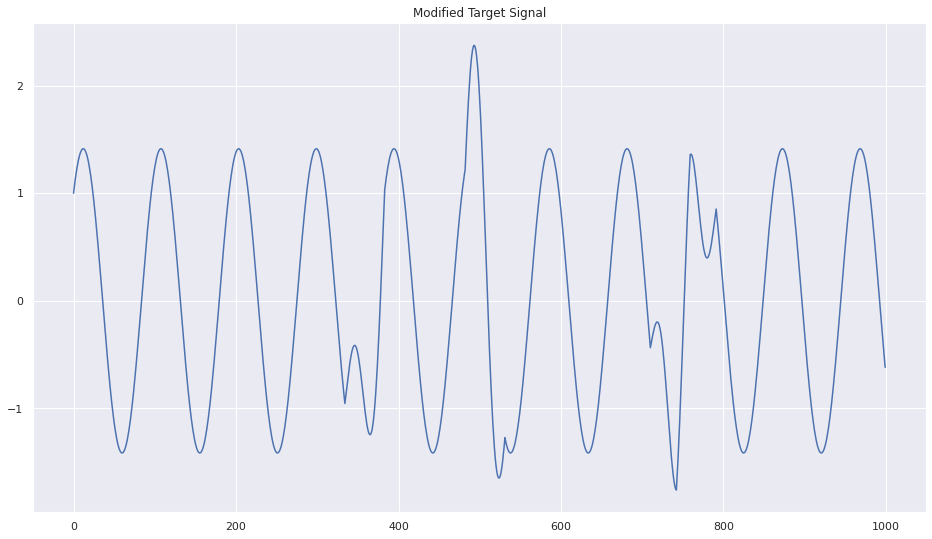

In [ ]:
_ = plt.plot(toy_df["sin + cos"].values[:1000])
_ = plt.title("Modified Target Signal", fontsize=20)

## Dataset

Create dataset containing images and features.

In [ ]:
for index in range(100):
    toy_df[f"2d_sensor_at_{index}"] = toy_2d_time_series[:, index]

toy_df.head()

,sin,cos,sin + cos,cos(0.5t),2d_sensor_at_0,2d_sensor_at_1,2d_sensor_at_2,2d_sensor_at_3,2d_sensor_at_4,2d_sensor_at_5,2d_sensor_at_6,2d_sensor_at_7,2d_sensor_at_8,2d_sensor_at_9,2d_sensor_at_10,2d_sensor_at_11,2d_sensor_at_12,2d_sensor_at_13,2d_sensor_at_14,2d_sensor_at_15,2d_sensor_at_16,2d_sensor_at_17,2d_sensor_at_18,2d_sensor_at_19,2d_sensor_at_20,2d_sensor_at_21,2d_sensor_at_22,2d_sensor_at_23,2d_sensor_at_24,2d_sensor_at_25,2d_sensor_at_26,2d_sensor_at_27,2d_sensor_at_28,2d_sensor_at_29,2d_sensor_at_30,2d_sensor_at_31,2d_sensor_at_32,2d_sensor_at_33,2d_sensor_at_34,2d_sensor_at_35,...,2d_sensor_at_60,2d_sensor_at_61,2d_sensor_at_62,2d_sensor_at_63,2d_sensor_at_64,2d_sensor_at_65,2d_sensor_at_66,2d_sensor_at_67,2d_sensor_at_68,2d_sensor_at_69,2d_sensor_at_70,2d_sensor_at_71,2d_sensor_at_72,2d_sensor_at_73,2d_sensor_at_74,2d_sensor_at_75,2d_sensor_at_76,2d_sensor_at_77,2d_sensor_at_78,2d_sensor_at_79,2d_sensor_at_80,2d_sensor_at_81,2d_sensor_at_82,2d_sensor_at_83,2d_sensor_at_84,2d_sensor_at_85,2d_sensor_at_86,2d_sensor_at_87,2d_sensor_at_88,2d_sensor_at_89,2d_sensor_at_90,2d_sensor_at_91,2d_sensor_at_92,2d_sensor_at_93,2d_sensor_at_94,2d_sensor_at_95,2d_sensor_at_96,2d_sensor_at_97,2d_sensor_at_98,2d_sensor_at_99
2015-01-01 00:00:00,0.000000,1.000000,1.000000,-1.000000,0.004654,-0.111822,-0.019400,-0.139148,0.075048,0.014867,0.110123,-0.017153,-0.153344,0.119604,-0.008874,0.051668,-0.010165,0.188952,0.134273,0.011771,-0.077991,-0.150953,0.008562,-0.009735,-0.107624,-0.233343,0.011435,-0.156245,-0.046466,-0.009095,0.263407,0.028870,-0.232922,-0.070511,0.148759,-0.024855,0.123093,-0.087303,-0.064233,0.099018,...,-0.015060,-0.048887,-0.121712,0.241067,0.092846,0.118752,0.069550,-0.173937,0.095272,-0.033446,0.012278,0.057550,0.047256,0.133300,-0.095784,0.029883,0.153190,0.014992,-0.040184,0.084330,0.009530,0.058918,0.107037,-0.068419,-0.047983,-0.083072,-0.083306,0.097180,-0.030375,-0.032088,-0.020919,-0.002756,-0.031921,-0.001710,0.004977,0.059269,0.070020,-0.127282,0.188139,0.140933
2015-01-01 00:01:00,0.032847,0.999460,1.063501,-0.999865,0.032960,-0.062124,-0.111696,0.116767,-0.032907,0.096928,-0.013632,0.073029,-0.185833,-0.054856,0.027309,0.121038,-0.008693,0.067677,-0.127062,0.134612,-0.019620,-0.023100,-0.021739,0.087373,-0.010127,-0.039510,-0.099383,-0.144494,0.108429,-0.125432,-0.005211,0.088704,0.118766,-0.010934,0.070784,-0.011104,-0.016184,-0.118647,0.116736,0.174304,...,0.050110,-0.098872,-0.144589,0.004240,-0.101934,0.016316,0.037860,-0.080788,-0.049129,-0.096056,-0.157940,0.161748,-0.093379,-0.120305,0.117332,-0.174017,0.051404,0.165523,0.074139,0.060366,0.024253,0.010810,-0.049497,0.094861,0.085664,0.021192,-0.006459,-0.062578,0.003299,-0.061732,0.005725,0.150367,0.110599,-0.022497,0.174012,-0.071872,-0.007178,-0.158235,-0.108087,0.006523
2015-01-01 00:02:00,0.065659,0.997842,1.122413,-0.999460,-0.012060,-0.144514,-0.095429,-0.106561,0.057726,-0.055847,0.150012,0.054746,-0.179762,0.101413,0.053575,-0.038066,0.150421,0.004578,-0.046379,-0.193192,0.119165,0.028235,-0.134578,-0.129830,0.059352,0.048462,-0.042787,-0.161474,-0.140780,-0.084857,0.034222,0.021253,-0.075428,-0.021375,0.263913,-0.153019,0.043082,0.227289,0.112786,0.103742,...,0.096544,0.075568,0.017168,-0.000667,0.023949,-0.094017,0.045847,-0.070124,0.005766,-0.120156,0.168661,-0.013737,0.007873,-0.012166,0.003630,0.089290,-0.096786,0.018354,0.051104,-0.069203,0.077937,-0.100520,-0.106486,-0.028189,-0.000074,0.128529,-0.013292,0.060510,-0.085169,0.013912,0.152199,-0.022813,-0.041817,0.018598,-0.027126,0.235914,-0.058209,0.154504,0.001371,-0.174247
2015-01-01 00:03:00,0.098400,0.995147,1.176480,-0.998786,-0.046120,-0.046358,-0.089684,0.109472,-0.011131,-0.078077,-0.079876,-0.024500,-0.122997,0.009563,0.018062,-0.141212,-0.024096,0.094481,0.047215,0.048584,-0.057126,0.103108,0.007358,0.024421,0.097584,0.129629,0.055352,-0.138877,-0.022423,0.108093,-0.116171,0.029889,-0.055222,0.032739,0.089315,0.145102,-0.008366,0.022472,-0.094117,0.001293,...,0.007029,

In [ ]:
generator = WindowGenerator(toy_df, input_window_size=30, output_window_size=30, shift=10, test_size=0.3, target_columns=["sin", "cos", "sin + cos", "cos(0.5t)"])

Features now are all inputs including 2D time series and outputs are the same 4 columns as previously.

In [ ]:
features, targets = generator.train
print(f"Features -> {features.shape}\nTargets ->  {targets.shape}")

Features -> (6849, 30, 104)
Targets ->  (6849, 30, 4)


## CNN Model
Model with CNN layers additing additional updates to generated outputs.

In [ ]:
class ConvResidualFeedbackModel(tf.keras.Model):
    def __init__(self, n_input_features, n_output_features, n_input_time_steps, n_output_time_steps, conv_input_size):
        super().__init__()
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
        self.n_input_time_steps = n_input_time_steps
        self.n_output_time_steps = n_output_time_steps
        self.conv_input_size = conv_input_size
        # use two GRU cells 
        self.cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(32), tf.keras.layers.GRUCell(16)])
        self.rnn = tf.keras.layers.RNN(self.cells, return_state=True)
        self.dense = tf.keras.layers.Dense(n_output_features, kernel_initializer="zeros", use_bias=False)

        self.conv_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.n_input_time_steps, self.conv_input_size, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 5), activation="relu"),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(3, 5), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.n_output_features * self.n_output_time_steps, activation="linear", kernel_initializer="zeros", use_bias=False),
            tf.keras.layers.Reshape(target_shape=(self.n_output_time_steps, self.n_output_features)),
        ])

    def warmup(self, inputs):
        # just output features go through warmup
        # inputs.shape => (batch, time, output_features)
        inputs = inputs[:, :, :self.n_input_features]
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)
        # predictions.shape => (batch, output_features)
        prediction = self.dense(x)
        # when using tf.keras.layers.StackedRNNCells state must be passed as a tuple!
        return prediction, tuple(state)

    def call(self, inputs, training=None):
        # initially empty not to break model class
        predictions = tf.TensorArray(size=self.n_output_time_steps, dtype=tf.float32)
        rnn_inputs = inputs[:, :, :self.n_input_features]
        cnn_inputs = inputs[:, :, self.n_input_features:]
        # just output features
        update, state = self.warmup(rnn_inputs)

        prediction = tf.cast(rnn_inputs[:, -1, :], dtype=tf.float32) + update
        predictions = predictions.write(0, prediction)  # initalize with last input + update

        for n in tf.range(1, self.n_output_time_steps):
            # Use the last prediction as input.
            prediction += update 
            x = prediction
            # Execute one lstm step.
            x, state = self.cells(x, states=state, training=training)
            # Convert the lstm output to a prediction.
            update = self.dense(x, training=training)
            # Add the prediction to the output
            predictions = predictions.write(n, prediction + update)

        # expand dims, because CNN requires channel dimension
        cnn_updates = self.conv_model(tf.expand_dims(cnn_inputs, axis=-1), training=training)
        predictions = predictions.stack()
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions + cnn_updates

model = ConvResidualFeedbackModel(n_input_features=4, n_output_features=4, n_input_time_steps=30, n_output_time_steps=30, conv_input_size=100)

## Unwrap CNN Model

In [ ]:
features, targets = generator.test  # use test data

input = tf.expand_dims(features[0], axis=0)
label = targets[0]

Warmup outputs zeros, just like before. It only outputs updates for target features.

In [ ]:
x, state = model.warmup(input)
x.numpy()

array([[-0.02887319,  0.01272822,  0.0109299 ,  0.00796332]],
      dtype=float32)

CNN updates are initially zeros as well, strides of the model must be chosen to match the shape of input, which is not usual image, but rather it is array with time and space axes. Strides in time should be smaller than in space. Conv model outputs updates to all time steps at once.

In [ ]:
cnn_updates = model.conv_model(tf.expand_dims(input[:, :, model.n_input_features:], axis=-1))
cnn_updates.numpy()

array([[[ 2.3511134e-03, -1.1078385e-03,  6.4141788e-03, -5.8247329e-04],
        [ 4.0062992e-03, -4.9179988e-03, -5.7981685e-03, -2.5313389e-03],
        [ 3.8111762e-03, -4.9162889e-03, -6.3587511e-03, -2.5663578e-03],
        [ 3.7532446e-03, -4.5068585e-03, -5.6309020e-03, -2.9895366e-03],
        [ 3.6256337e-03, -4.1008927e-03, -3.9152862e-03, -3.2442843e-03],
        [ 2.9780173e-03, -3.5883363e-03, -2.8229197e-03, -3.9002376e-03],
        [ 2.4839337e-03, -3.2382146e-03, -8.2710246e-04, -4.8162965e-03],
        [ 1.9060611e-03, -3.0205993e-03,  4.8300950e-04, -5.6296857e-03],
        [ 1.2242508e-03, -2.9081863e-03,  1.0219854e-03, -6.3920361e-03],
        [ 4.0045171e-04, -2.8576215e-03,  5.7608634e-04, -7.1343849e-03],
        [-2.6559923e-04, -2.8112365e-03, -7.0962124e-05, -7.7959872e-03],
        [-7.7848451e-04, -2.7456877e-03, -7.7310763e-04, -8.2656275e-03],
        [-1.1827685e-03, -2.6400371e-03, -3.2511847e-03, -8.5164085e-03],
        [-1.5804340e-03, -2.4809460e-0

Summary of CNN model.

In [ ]:
model.conv_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 20, 32)        320       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 9, 4, 16)          4624      
_________________________________________________________________
flatten_16 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 120)               69120     
_________________________________________________________________
reshape_1 (Reshape)          (None, 30, 4)             0         
Total params: 74,064
Trainable params: 74,064
Non-trainable params: 0
_________________________________________________________________


## Fit 


In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
history = model.fit(features, targets, epochs=10, validation_split=0.1, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/10
83/83 [==============================] - 10s 61ms/step - loss: 0.2670 - mse: 0.2670 - mae: 0.3020 - val_loss: 0.1064 - val_mse: 0.1064 - val_mae: 0.1798
Epoch 2/10
83/83 [==============================] - 5s 55ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1274 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1001
Epoch 3/10
83/83 [==============================] - 5s 55ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.0796 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.0843
Epoch 4/10
83/83 [==============================] - 5s 55ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0669 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.0682
Epoch 5/10
83/83 [==============================] - 5s 56ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0598 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.0605
Epoch 6/10
83/83 [==============================] - 5s 57ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0563 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.0615
Epoch 7/10
83/83 [===

In [ ]:
test_features, test_targets = generator.test
predictions = model.predict(test_features)

regression_report(y_true=test_targets.flatten(), y_pred=predictions.flatten())

MSE: 0.0119
MAE: 0.0430
MAX: 2.7614
R2:  0.9818


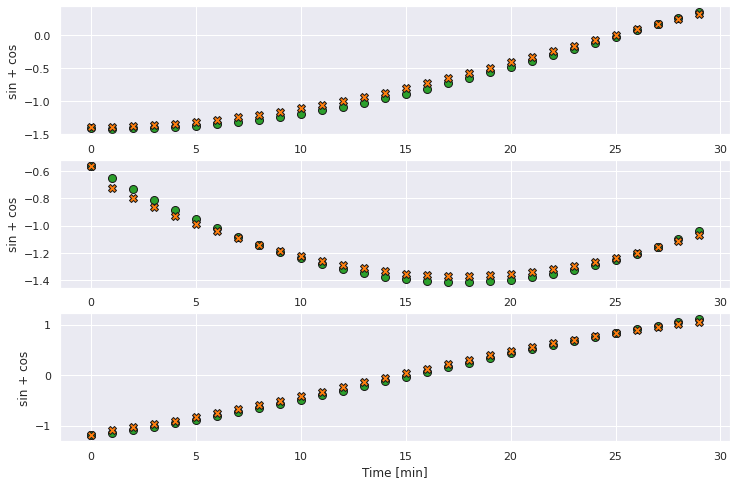

In [ ]:
plot_window(generator, "sin + cos", model=model, dataset="test")

Use fitted model to predict on `"sin + cos"` column. Display plot from start to end using test generator.

In [ ]:
test_generator = WindowGenerator(toy_df, input_window_size=30, output_window_size=30, shift=30, test_size=0.3, target_columns=["sin", "cos", "sin + cos", "cos(0.5t)"])
test_features, _ = test_generator.test

predictions = model.predict(test_features)
predictions = predictions[:,:,2].flatten()

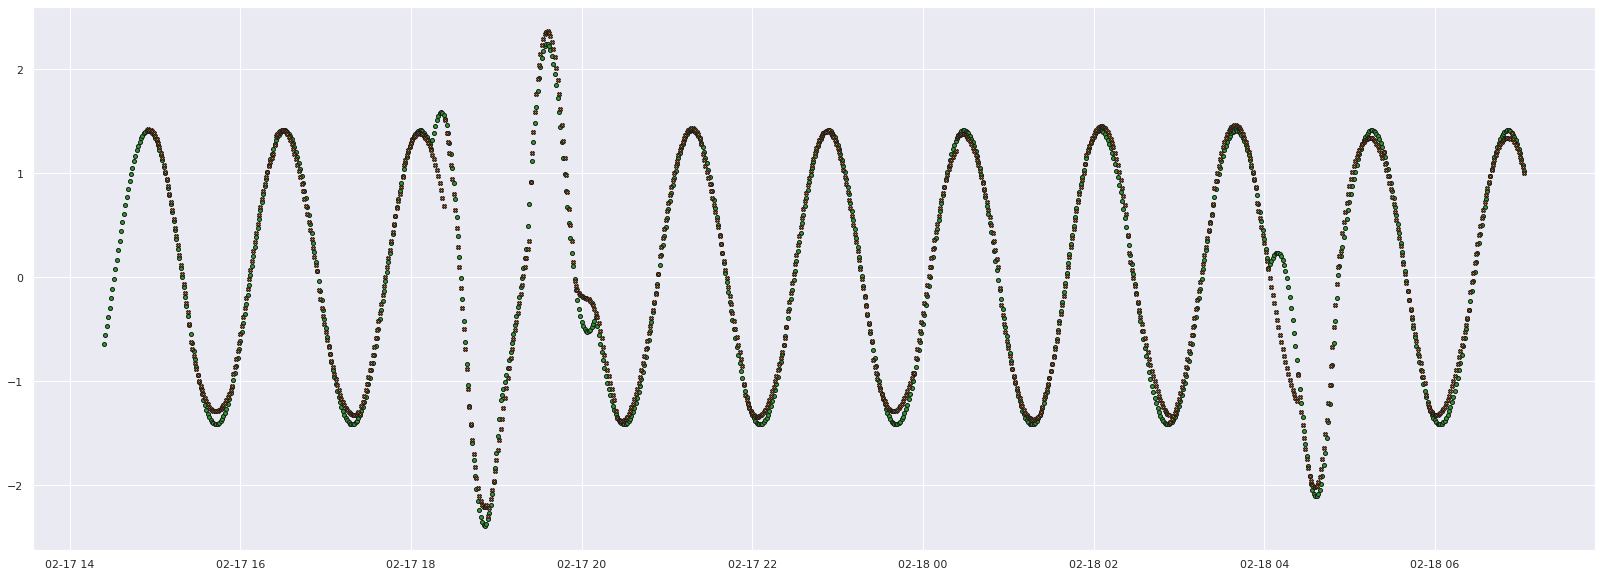

In [ ]:
_ = plt.figure(figsize=[28, 10])
_ = plt.scatter(generator.test_df.index[:1000], generator.test_df["sin + cos"].values[:1000], edgecolors='k', label='Labels', c='#2ca02c', s=16)
_ = plt.scatter(generator.test_df.index[30:1000], predictions[:(1000 - 30)], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=16)